In [1]:
import os, datetime, argparse, tqdm, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from os.path import join as pjoin

os.environ["CUDA_VISIBLE_DEVICES"]="0"

2023-02-27 15:29:32.407127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import utils
import mymodels

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--file_traf', type = str, default = '../prepdata/traffic-volume-A-20180101-20190101.df')
parser.add_argument('--file_coarse', type = str, default = '../prepdata/coarse_grained_lte.h5')
parser.add_argument('--file_fine', type = str, default = '../prepdata/fine_grained_lte.h5')

parser.add_argument('--model_name', type = str, default = 'MySample')
parser.add_argument('--memo', type = str, default = '')
parser.add_argument('--save_dir', default = 'test', help = 'save_dir')

parser.add_argument('--train_ratio', type = float, default = 0.7,
                    help = 'training set [default : 0.7]')
parser.add_argument('--val_ratio', type = float, default = 0.1,
                    help = 'validation set [default : 0.1]')
parser.add_argument('--test_ratio', type = float, default = 0.2,
                    help = 'testing set [default : 0.2]')
# parser.add_argument('--cnn_size', type = int, default = 3)
parser.add_argument('--P', type = int, default = 6)
parser.add_argument('--Q', type = int, default = 1)
parser.add_argument('--time_slot', type = int, default = 60, help = 'a time step is 60 mins')

parser.add_argument('--eta', type = float, default = 0.01,
                    help = 'weight of mmd')
parser.add_argument('--L', type = int, default = 3,
                    help = 'number of STAtt Blocks')
# parser.add_argument('--LZ', type = int, default = 2,
#                     help = 'number of Regional STAtt Blocks')
parser.add_argument('--K', type = int, default = 8,
                    help = 'number of attention heads')
parser.add_argument('--d', type = int, default = 8,
                    help = 'dims of each head attention outputs')
parser.add_argument('--D', type = int, default = 64)
parser.add_argument('--batch_size', type = int, default = 32,
                    help = 'batch size')
parser.add_argument('--max_epoch', type = int, default = 1000,
                    help = 'epoch to run')
parser.add_argument('--patience', type = int, default = 20,
                    help = 'patience for early stop')
parser.add_argument('--learning_rate', type=float, default = 0.001,
                    help = 'initial learning rate')
parser.add_argument('--decay_epoch', type=int, default = 5,
                    help = 'decay epoch')


args = parser.parse_args([])

    
args.test_name = args.memo + args.model_name

args.model_checkpoint_dir = f'checkpoint/'
args.model_checkpoint = os.path.join(args.model_checkpoint_dir, args.test_name)
args.test_dir = f'test_exp/'

if not os.path.isdir(args.model_checkpoint_dir):
    os.makedirs(args.model_checkpoint_dir)
if not os.path.isdir(args.test_dir):
    os.makedirs(args.test_dir)


# (trainX, trainZC, trainZF, trainTE, trainY, 
#             valX, valZC, valZF, valTE, valY, 
#             testX, testZC, testZF, testTE, testY, extdata) = utils.loadVolumeData2(args)

In [4]:
from utils import *
def loadVolumeAE(args):
    #traf_df = pd.read_csv(args.filepath, index_col=0, parse_dates=True)
    traf_df = pd.read_hdf(args.file_traf)
    coarse_df = pd.read_hdf(args.file_coarse)
    # coarse_zero = np.zeros((1, len(coarse_df.columns)), dtype=np.float32)
    # coarse_diff = np.concatenate((coarse_zero, np.diff(coarse_df.values, axis=0)), 0)
    # coarse_diff_df = pd.DataFrame(coarse_diff, columns=coarse_df.columns)
    # coarse_diff_df.index = coarse_df.index
    # coarse_df = coarse_diff_df

    fine_df = pd.read_hdf(args.file_fine)
    # fine_zero = np.zeros((1, len(fine_df.columns)), dtype=np.float32)
    # fine_diff = np.concatenate((fine_zero, np.diff(fine_df.values, axis=0)), 0)
    # fine_diff_df = pd.DataFrame(fine_diff, columns=fine_df.columns)
    # fine_diff_df.index = fine_df.index
    # fine_df = fine_diff_df
    
    traf_df = traf_df.iloc[:24*7*30]
    coarse_df = coarse_df.iloc[:24*7*30]
    fine_df = fine_df.iloc[:24*7*30]

    sid_list = []
    traf_vals = np.nan_to_num(traf_df.values.astype(np.float32))
    for sid, val in enumerate(np.sum(traf_vals == 0, 0)):
        if val < traf_vals.shape[0]*0.3:
            sid_list.append(traf_df.columns[sid])
            
    
    traf_df = traf_df[sid_list]
    print('traf_df', len(sid_list), traf_df.shape)

    extdata = dict()

    Traffic = np.nan_to_num(traf_df.values.astype(np.float32))
    # Traffic_fill = fill_missing(traf_df).values.astype(np.float32)
    num_step, num_sensors = traf_df.shape; extdata['num_nodes'] = num_sensors
    
    # train/val/test 
    train_steps = round(args.train_ratio * num_step)
    test_steps = round(args.test_ratio * num_step)
    val_steps = num_step - train_steps - test_steps

    
    # train_fill = train_traf = Traffic_fill[: train_steps]
    # val_fill = Traffic_fill[train_steps : train_steps + val_steps]
    # test_fill = Traffic_fill[-test_steps :]


    Traffic = np.nan_to_num(traf_df.values.astype(np.float32))
    train = Traffic[: train_steps]
    val = Traffic[train_steps : train_steps + val_steps]
    test = Traffic[-test_steps :]
    
    trainX, trainY = seq2instance(train, args.P, args.Q)
    valX, valY = seq2instance(val, args.P, args.Q)
    testX, testY = seq2instance(test, args.P, args.Q)
    # normalization
    maxval = np.max(train) + 1; extdata['maxval'] = maxval 
    trainX = trainX / maxval
    valX = valX / maxval
    testX = testX / maxval
    
    
    CoarseLTE = np.nan_to_num(coarse_df.values.astype(np.float32))
    CH, CW = coarse_df.columns[-1].split(','); CH = int(CH)+1; CW = int(CW)+1; 
    extdata['CH'] = CH; extdata['CW'] = CW
    CoarseLTE = CoarseLTE.reshape(-1, CH, CW)

    train = CoarseLTE[: train_steps]
    val = CoarseLTE[train_steps : train_steps + val_steps]
    test = CoarseLTE[-test_steps :]


    # X, Y 
    trainZC, _ = seq2instance(train, args.P, args.Q)
    valZC, _ = seq2instance(val, args.P, args.Q)
    testZC, _ = seq2instance(test, args.P, args.Q)
    # normalization
    maxvalZC = np.max(train) + 1; extdata['maxvalZC'] = maxvalZC
    trainZC = trainZC / maxvalZC
    valZC = valZC / maxvalZC
    testZC = testZC / maxvalZC

    
    # fine train/val/test
    FineLTE = np.nan_to_num(fine_df.values.astype(np.float32))
    FH, FW = fine_df.columns[-1].split(','); FH = int(FH)+1; FW = int(FW)+1
    extdata['FH'] = FH; extdata['FW'] = FW
    FineLTE = FineLTE.reshape(-1, FH, FW)
    
    train = FineLTE[: train_steps]
    val = FineLTE[train_steps : train_steps + val_steps]
    test = FineLTE[-test_steps :]

    # X, Y 
    trainZF, _ = seq2instance(train, args.P, args.Q)
    valZF, _ = seq2instance(val, args.P, args.Q)
    testZF, _ = seq2instance(test, args.P, args.Q)
    # normalization
    maxvalZF = np.max(train) + 1; extdata['maxvalZF'] = maxvalZF
    trainZF = trainZF / maxvalZF
    valZF = valZF / maxvalZF
    testZF = testZF / maxvalZF
    
    # temporal embedding 
    Time = traf_df.index
    dayofweek =  np.reshape(Time.weekday, newshape = (-1, 1))
    timeofday = (Time.hour * 3600 + Time.minute * 60 + Time.second) \
                // (args.time_slot*60) #// Time.freq.delta.total_seconds()
    timeofday = np.reshape(timeofday, newshape = (-1, 1))    
    Time = np.concatenate((dayofweek, timeofday), axis = -1)
    # train/val/test
    train = Time[: train_steps]
    val = Time[train_steps : train_steps + val_steps]
    test = Time[-test_steps :]
    # shape = (num_sample, P + Q, 2)
    trainTE = seq2instance(train, args.P, args.Q)
    trainTE = np.concatenate(trainTE, axis = 1).astype(np.int32)
    valTE = seq2instance(val, args.P, args.Q)
    valTE = np.concatenate(valTE, axis = 1).astype(np.int32)
    testTE = seq2instance(test, args.P, args.Q)
    testTE = np.concatenate(testTE, axis = 1).astype(np.int32)

    
    return (trainX, trainZC, trainZF, trainTE, trainY, 
            valX, valZC, valZF, valTE, valY, 
            testX, testZC, testZF, testTE, testY, extdata)

In [5]:
(trainX, trainZC, trainZF, trainTE, trainY, 
            valX, valZC, valZF, valTE, valY, 
            testX, testZC, testZF, testTE, testY, extdata) = loadVolumeAE(args)

traf_df 41 (5040, 41)


In [6]:
extdata

{'num_nodes': 41,
 'maxval': 3430.0,
 'CH': 31,
 'CW': 38,
 'maxvalZC': 138193.96875,
 'FH': 30,
 'FW': 33,
 'maxvalZF': 60666.1640625}

In [7]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from submodules import *

def custom_mae_loss_inside(label, pred):
    mask = tf.not_equal(label, 0)
    mask = tf.cast(mask, tf.float32)
    mask /= tf.reduce_mean(mask)
    mask = tf.compat.v2.where(
        condition = tf.math.is_nan(mask), x = 0., y = mask)
    loss = tf.abs(tf.subtract(pred, label))
    loss *= mask
    loss = tf.compat.v2.where(
        condition = tf.math.is_nan(loss), x = 0., y = loss)
    loss = tf.reduce_mean(loss)
    return loss


class BipartiteAttentionViz(tf.keras.layers.Layer):
    def __init__(self, K, d):
        super(BipartiteAttentionViz, self).__init__()
        self.K = K
        self.d = d
        self.D = K*d

    def build(self, input_shape):
        self.FC_Q = keras.Sequential([
            layers.Dense(self.D, activation="relu")])
        self.FC_K = keras.Sequential([
            layers.Dense(self.D, activation="relu")])
        self.FC_V = keras.Sequential([
            layers.Dense(self.D, activation="relu")])
        self.FC_X = keras.Sequential([
            layers.Dense(self.D, activation="relu"),
            layers.Dense(self.D)])
        
    def call(self, query, key, value):
        K = self.K
        d = self.d
        D = self.D
        
        print(query.shape, key.shape, value.shape)
        
        query = self.FC_Q(query)
        key = self.FC_K(key)
        value = self.FC_V(value)

        print('QKV', query.shape, key.shape, value.shape)
    
        query = tf.concat(tf.split(query, K, axis = -1), axis = 0)
        key = tf.concat(tf.split(key, K, axis = -1), axis = 0)
        value = tf.concat(tf.split(value, K, axis = -1), axis = 0)
        
        
        
        # query = tf.transpose(query, perm = (0, 2, 1, 3))
        # key = tf.transpose(key, perm = (0, 2, 3, 1))
        # value = tf.transpose(value, perm = (0, 2, 1, 3))   
    
        attention = tf.matmul(query, key, transpose_b = True)
        attention /= (d ** 0.5)
        attention = tf.nn.softmax(attention, axis = -1)
        
        # [batch_size, num_step, N, D]
        X = tf.matmul(attention, value)
        #print('attention.shape, value.shape', attention.shape, value.shape, X.shape)
        # X = tf.transpose(X, perm = (0, 2, 1, 3))
        X = tf.concat(tf.split(X, K, axis = 0), axis = -1)
        X = self.FC_X(X)
        
        return X, attention
    
class MySample(tf.keras.layers.Layer):
    def __init__(self, extdata, args):
        super(MySample, self).__init__()
        self.D = args.D
        self.K = args.K
        self.d = args.d
        self.L = args.L
        self.num_nodes = extdata['num_nodes']
        self.P = args.P
        self.Q = args.Q
        # self.SE = extdata['SE']
        self.CH = extdata['CH']
        self.CW = extdata['CW']
        def cnn_dim(W):
            W = (W-3)//2 + 1
            W = (W-3)//2 + 1
            return W
        self.CNH = cnn_dim(self.CH)
        self.CNW = cnn_dim(self.CW)
        self.num_cells_C = cnn_dim(self.CH) * cnn_dim(self.CW)
        
    def build(self, input_shape):
        D = self.D
        self.STE_layer = STEmbedding(self.num_nodes, D)
        self.SE = self.add_weight(shape=(self.num_nodes, self.D),
                                        initializer='glorot_uniform',
                                        name='SE', dtype=tf.float32)
        
        self.GSTAC_enc = [GSTAttBlock(self.K, self.d) for _ in range(self.L)]
        self.C_trans_layer = TransformAttention(self.K, self.d)
        self.GSTAC_dec = [GSTAttBlock(self.K, self.d) for _ in range(self.L)]
        
        
        
        self.FC_XC_in = keras.Sequential([
                        layers.Dense(D, activation="relu"),
                        layers.Dense(D)])
        
        # self.FC_XC_out = keras.Sequential([
        #                 layers.Dense(D, activation="relu"),
        #                 layers.Dense(1)])


        ##################################
        
        self.STEZC_layer = STEmbedding(self.num_cells_C, D)
        self.SEZC = self.add_weight(shape=(self.num_cells_C, D),
                                        initializer='glorot_uniform',
                                        name='SEZC', dtype=tf.float32)
        self.FC_ZC_Conv = keras.Sequential([
                                layers.Conv2D(D, 3, strides=(2, 2), padding='valid'),
                                layers.BatchNormalization(),
                                layers.LeakyReLU(),
                                layers.Conv2D(D, 3, strides=(2, 2), padding='valid'),
                                layers.BatchNormalization(),
                            ])
        self.RSTA_enc = GSTAttBlock(self.K, self.d)
        self.XC_trans_layer = BipartiteAttentionViz(self.K, self.d)

        self.GSTAC_enc2 = [GSTAttBlock(self.K, self.d) for _ in range(self.L)]
        self.C_trans_layer2 = TransformAttention(self.K, self.d)
        self.GSTAC_dec2 = [GSTAttBlock(self.K, self.d) for _ in range(self.L)]
        # self.FC_XC_out2 = keras.Sequential([
        #                 layers.Dense(D, activation="relu"),
        #                 layers.Dense(1)])
        self.FC_XM = keras.Sequential([
                            layers.Dense(D, activation="relu"),
                            layers.Dense(1)])
        self.gated_fusion = GatedFusion(self.D)
        self.FC_final = keras.Sequential([
                            layers.Dense(D, activation="relu"),
                            layers.Dense(1)], name='FC_final')

        
    def call(self, X, ZC, ZF, TE):
        X0 = X
        TE = tf.cast(TE, tf.int32)
        mask = tf.not_equal(X0, 0)
        mask = tf.cast(mask, tf.float32)
        
        STE = self.STE_layer(self.SE, TE)
        STEX_P, STEX_Q = STE[:, :self.P, :], STE[:, self.P:, :]

        X = tf.expand_dims(X0, -1)
        X = self.FC_XC_in(X) 
        for i in range(self.L):
            X = self.GSTAC_enc[i](X, STEX_P)
        X = self.C_trans_layer(X, STEX_P, STEX_Q)
        for i in range(self.L):
            X = self.GSTAC_dec[i](X, STEX_Q)
        YY1 = X
        # X = self.FC_XC_out(X)
        # Y1 = tf.squeeze(X, -1)

        ###############################
        STEZ = self.STEZC_layer(self.SEZC, TE)
        STEZ_P, STEZ_Q = STEZ[:, :self.P, :], STEZ[:, self.P:, :]

        if len(ZC.shape) == 4:
            ZC = tf.expand_dims(ZC, -1)
        ZC = self.FC_ZC_Conv(ZC)
        ZC = tf.reshape(ZC, (-1, self.P, ZC.shape[2]*ZC.shape[3], self.D))

        ZC = self.RSTA_enc(ZC, STEZ_P)
        
        ZX, attention = self.XC_trans_layer(STEX_P, STEZ_P, ZC)

        X_gen = self.FC_XM(ZX)[..., 0]
        X = mask*X0 + (1-mask)*X_gen
        custom_loss = 0*custom_mae_loss_inside(X0, X_gen)
        self.add_loss(custom_loss)

        for i in range(self.L):
            ZX = self.GSTAC_enc2[i](ZX, STEX_P)
        ZX = self.C_trans_layer2(ZX, STEX_P, STEX_Q)
        for i in range(self.L):
            ZX = self.GSTAC_dec2[i](ZX, STEX_Q)
        YY2 = ZX
        # ZX = self.FC_XC_out2(ZX)
        # Y2 = tf.squeeze(ZX, -1)

        # Y = Y1 + Y2

        
        Y = self.FC_final(self.gated_fusion(YY1, YY2))
        Y = tf.squeeze(Y, -1)


        return Y, attention

In [8]:
def model_define():
    X = layers.Input(shape=trainX.shape[1:], dtype=tf.float32)
    ZC = layers.Input(shape=trainZC.shape[1:], dtype=tf.float32)
    ZF = layers.Input(shape=trainZF.shape[1:], dtype=tf.float32)
    TE = layers.Input(shape=trainTE.shape[1:], dtype=tf.int32) # int32
    
    model = MySample(extdata, args)
    Y, attention = model(X, ZC, ZF, TE)
    
    Y = Y * extdata['maxval']
    model = keras.models.Model((X, ZC, ZF, TE), Y)

    return model


model = model_define()
# model.load_weights(args.model_checkpoint).expect_partial()
model.summary()
optimizer = keras.optimizers.Adam(learning_rate=args.learning_rate)

2023-02-27 15:29:34.276731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 15:29:34.295064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 15:29:34.295364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 15:29:34.296129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

SE (41, 64) TE (None, 7, 2)
SE (56, 64) TE (None, 7, 2)
(None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
QKV (None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 41)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6, 31, 38)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 6, 30, 33)]  0           []                               
                                                                                                  
 input_4 (InputLayer)    

In [9]:

def custom_mae_loss(label, pred):
    mask = tf.not_equal(label, 0)
    mask = tf.cast(mask, tf.float32)
    mask /= tf.reduce_mean(mask)
    mask = tf.compat.v2.where(
        condition = tf.math.is_nan(mask), x = 0., y = mask)
    loss = tf.abs(tf.subtract(pred, label))
    loss *= mask
    loss = tf.compat.v2.where(
        condition = tf.math.is_nan(loss), x = 0., y = loss)
    loss = tf.reduce_mean(loss)
    return loss

model.compile(loss=custom_mae_loss, optimizer=optimizer)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=args.patience)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=args.decay_epoch)
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath = args.model_checkpoint,
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = True,
    cooldown=3,
    mode = 'auto',
    save_freq='epoch',
)


model.fit(
    (trainX, trainZC, trainZF, trainTE), trainY,
    batch_size=args.batch_size,
    epochs=args.max_epoch,
    validation_data=((valX, valZC, valZF, valTE), valY),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
    # callbacks=[early_stopping, model_ckpt],
)

Epoch 1/1000
SE (41, 64) TE (None, 7, 2)
SE (56, 64) TE (None, 7, 2)
(None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
QKV (None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
SE (41, 64) TE (None, 7, 2)
SE (56, 64) TE (None, 7, 2)
(None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
QKV (None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)


2023-02-27 15:30:08.940743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-02-27 15:30:09.792687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-27 15:30:09.870367: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55f6e57f4a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-27 15:30:09.870400: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-02-27 15:30:09.875245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-27 15:30:09.958901: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

111/111 [==============================] - ETA: 0s - loss: 225.9978SE (41, 64) TE (None, 7, 2)
SE (56, 64) TE (None, 7, 2)
(None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
QKV (None, 6, 41, 64) (None, 6, 56, 64) (None, 6, 56, 64)
111/111 [==============================] - 62s 116ms/step - loss: 225.9978 - val_loss: 521.6400 - lr: 0.0010
Epoch 2/1000
111/111 [==============================] - 9s 78ms/step - loss: 133.7291 - val_loss: 450.4788 - lr: 0.0010
Epoch 3/1000
111/111 [==============================] - 9s 78ms/step - loss: 98.6535 - val_loss: 383.5780 - lr: 0.0010
Epoch 4/1000
111/111 [==============================] - 9s 77ms/step - loss: 87.3631 - val_loss: 295.2758 - lr: 0.0010
Epoch 5/1000
111/111 [==============================] - 9s 78ms/step - loss: 79.4136 - val_loss: 196.2164 - lr: 0.0010
Epoch 6/1000
111/111 [==============================] - 9s 81ms/step - loss: 71.8800 - val_loss: 126.3213 - lr: 0.0010
Epoch 7/1000
111/111 [==============================] - 9s 7


KeyboardInterrupt



In [11]:
layer = model.get_layer('my_sample')

In [12]:
predY, attention = layer(trainX, trainZC, trainZF, trainTE)

SE (41, 64) TE (3522, 7, 2)
SE (56, 64) TE (3522, 7, 2)
(3522, 6, 41, 64) (3522, 6, 56, 64) (3522, 6, 56, 64)
QKV (3522, 6, 41, 64) (3522, 6, 56, 64) (3522, 6, 56, 64)


In [13]:
att = attention.numpy()

In [14]:
att = att.reshape(predY.shape[0], 8, 6, attention.shape[2], attention.shape[3])

In [77]:
att.shape

(3522, 8, 6, 41, 56)

In [15]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

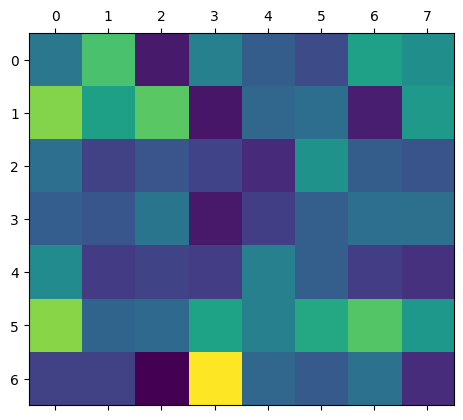

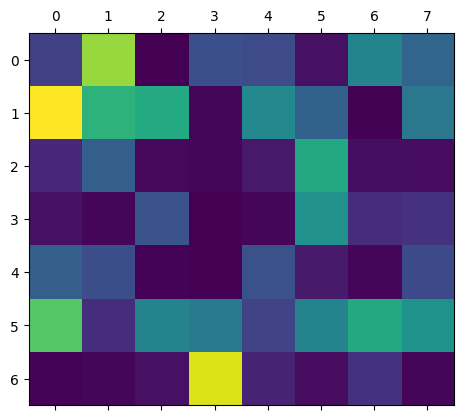

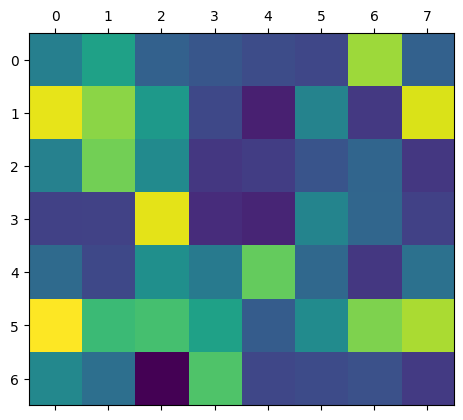

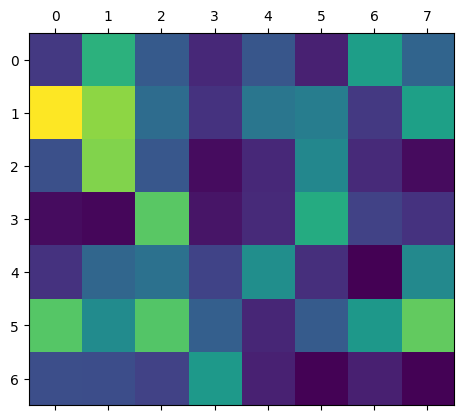

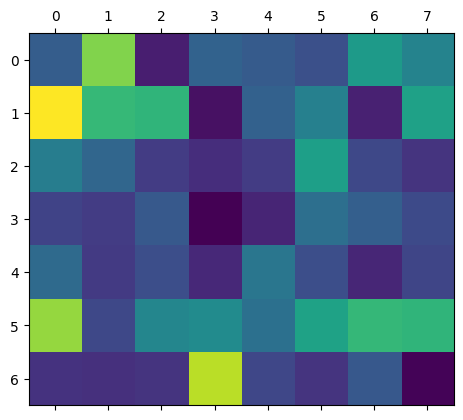

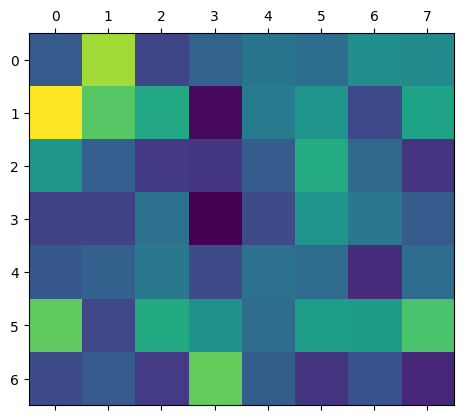

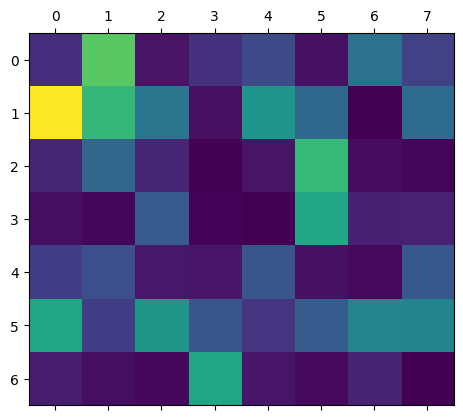

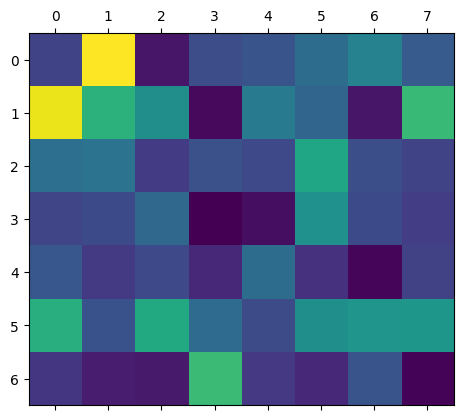

In [104]:
# batch#, attention head, time sequence, sensor#, region#
plt.matshow(att[0, 0, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 1, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 2, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 3, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 4, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 5, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 6, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.matshow(att[0, 7, -1, 6, :].reshape(layer.CNH, layer.CNW))

plt.show

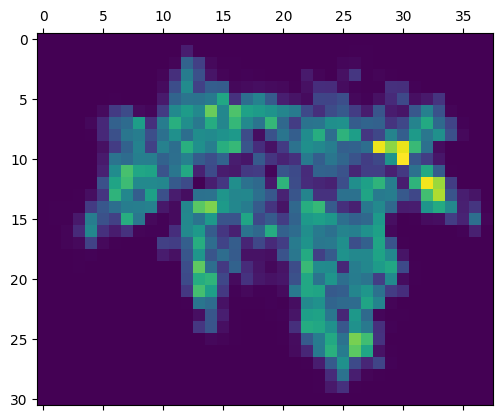

In [93]:
plt.matshow(trainZC[0, 0, :, :])